# Movie sentiment analysis

<img src='https://user-images.githubusercontent.com/31696557/48961509-28e70c00-ef9b-11e8-85f3-86a584d823de.png' width=300 height=233>


**Les membres de groupe:**

   - WIFKAOUI Yasmine
   - AL JADD Mohammed
   - TAIFI Assia
   - EL NABAOUI Nouhaila
   
   
**Lien du dataset :**
    <a href="https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews">IMDB Dataset of 50K Movie Reviews </a>
    
**Lien du fichier glove.6B.100d.txt :**
    <a href="https://www.kaggle.com/danielwillgeorge/glove6b100dtxt">IMDB Dataset of 50K Movie Reviews </a>

**Lien de notre video (presentation) :**
    <a href="https://drive.google.com/file/d/1MlP2EaMrBBlv3xOL7E9CLkxW1_0nT0e-/view?usp=sharing">Google Drive </a>
   

# Importation des librairies requises

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import array
from numpy import asarray
from numpy import zeros
import seaborn as sns
from time import time
import re
import nltk
from nltk.corpus import stopwords
from astropy.table import Table
from keras.layers import GRU, LSTM
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Importation et analyse du dataset

In [2]:
#Importer le dataset
movie_reviews = pd.read_csv("dataset.csv")

#Exploration du dataset
#Vérifier l'existence de valeur null
movie_reviews.isnull().values.any()

False

In [3]:
movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
movie_reviews.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,negative
freq,5,25000


In [6]:
movie_reviews["review"][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

<AxesSubplot:xlabel='sentiment', ylabel='count'>

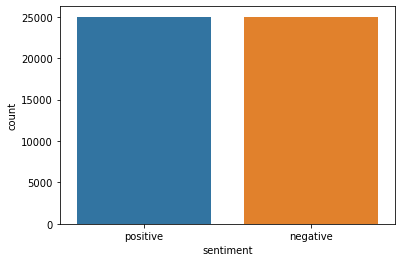

In [7]:
sns.countplot(x='sentiment', data=movie_reviews)

# Prétraitement des données

In [8]:
#Data Preprocessing
def preprocess_text(sen):
    # Suppression des balises HTML
    sentence = remove_tags(sen)

    # Supprimer les ponctuations et les chiffres
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Suppression d'un seul caractère
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Suppression de plusieurs espaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [10]:
#Prétraiter les avis et les stocker dans une nouvelle liste

X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

#Voir la quatrième critique
X[3]

'Basically there a family where little boy Jake thinks there a zombie in his closet his parents are fighting all the time This movie is slower than soap opera and suddenly Jake decides to become Rambo and kill the zombie OK first of all when you re going to make film you must Decide if its thriller or drama As drama the movie is watchable Parents are divorcing arguing like in real life And then we have Jake with his closet which totally ruins all the film expected to see BOOGEYMAN similar movie and instead watched drama with some meaningless thriller spots out of just for the well playing parents descent dialogs As for the shots with Jake just ignore them '

In [11]:
#Convertir les étiquettes en chiffres
y = movie_reviews['sentiment']

#Remplacer "positive" par le chiffre 1 et "negative" par le chiffre 0
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [12]:
#Diviser l'ensemble de données en ensembles d'entrainement et de test.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Préparation du Embedding Layer

In [13]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [14]:
# Ajout de 1 en raison de l'index 0 réservé
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [15]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [16]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Training :

# 1 - Classification de texte avec un réseau neuronal simple

<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRPe_iCPpjGjwkpgijF9PtgiPoWDdJ0LpKVmg&usqp=CAU'>

In [17]:
#Text Classification with Simple Neural Network

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [19]:
tic = time()
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
toc = time()
time1 = (toc-tic)

Epoch 1/6
250/250 [==============================] - 6s 23ms/step - loss: 0.5996 - acc: 0.6744 - val_loss: 0.5344 - val_acc: 0.7314
Epoch 2/6
250/250 [==============================] - 4s 18ms/step - loss: 0.4965 - acc: 0.7581 - val_loss: 0.5342 - val_acc: 0.7360
Epoch 3/6
250/250 [==============================] - 5s 20ms/step - loss: 0.4578 - acc: 0.7868 - val_loss: 0.5628 - val_acc: 0.7194 0s - loss:
Epoch 4/6
250/250 [==============================] - 5s 21ms/step - loss: 0.4339 - acc: 0.8003 - val_loss: 0.5401 - val_acc: 0.73273 - acc: 0
Epoch 5/6
250/250 [==============================] - 6s 24ms/step - loss: 0.4227 - acc: 0.8077 - val_loss: 0.5325 - val_acc: 0.7405
Epoch 6/6
250/250 [==============================] - 5s 21ms/step - loss: 0.4097 - acc: 0.8153 - val_loss: 0.5387 - val_acc: 0.7449


In [20]:
score = model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 6ms/step - loss: 0.5433 - acc: 0.7407


In [21]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracy_NN = score[1]

Test Score: 0.5433143973350525
Test Accuracy: 0.7407000064849854


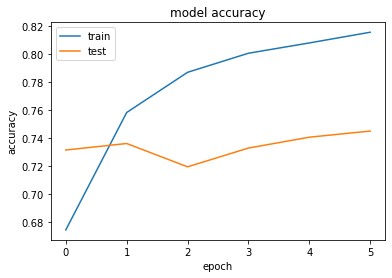

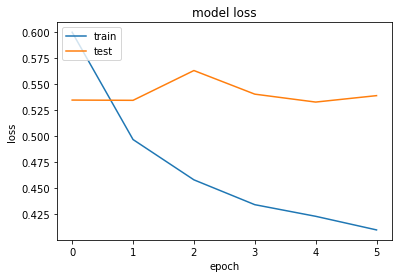

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Faire des prédictions sur une seule instance

In [23]:
#Prediction
instance = X[57]
print(instance)

I laughed all the way through this rotten movie It so unbelievable woman leaves her husband after many years of marriage has breakdown in front of real estate office What happens The office manager comes outside and offers her job Hilarious Next thing you know the two women are going at it Yep they re lesbians Nothing rings true in this Lifetime for Women with nothing better to do movie Clunky dialogue like don want to spend the rest of my life feeling like had chance to be happy and didn take it doesn help There a wealthy distant mother who disapproves of her daughter new relationship sassy black maid unbelievable that in the year film gets made in which there a sassy black maid Hattie McDaniel must be turning in her grave The woman has husband who freaks out and wants custody of the snotty teenage kids Sheesh No cliche is left unturned 


In [24]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.99992335]], dtype=float32)

# 1 - Classification de texte avec CNN

<img src='https://www.researchgate.net/publication/326152216/figure/fig2/AS:644307941879809@1530626392505/Deep-convolutional-neural-network-DCNN-architecture-A-schematic-diagram-of-AlexNet.png' width=300 height=300>

**Model CNN:**

In [25]:
# Le modele CNN
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [26]:
# Summary
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


**Training:**

In [27]:
tic = time()
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
toc = time()
time2 = (toc-tic)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 60s 239ms/step - loss: 0.5027 - acc: 0.7483 - val_loss: 0.3976 - val_acc: 0.8186
Epoch 2/6
250/250 [==============================] - 63s 251ms/step - loss: 0.3720 - acc: 0.8371 - val_loss: 0.3695 - val_acc: 0.8324
Epoch 3/6
250/250 [==============================] - 63s 251ms/step - loss: 0.3242 - acc: 0.8637 - val_loss: 0.3586 - val_acc: 0.8378
Epoch 4/6
250/250 [==============================] - 44s 177ms/step - loss: 0.2859 - acc: 0.8822 - val_loss: 0.3494 - val_acc: 0.8414
Epoch 5/6
250/250 [==============================] - 68s 273ms/step - loss: 0.2504 - acc: 0.9017 - val_loss: 0.3462 - val_acc: 0.8444
Epoch 6/6
313/313 [==============================] - 4s 12ms/step - loss: 0.3375 - acc: 0.8556


**Evaluation:**

In [28]:
scoreTrain = model.evaluate(X_train, y_train, verbose=1)

1250/1250 [==============================] - 30s 24ms/step - loss: 0.2080 - acc: 0.9293


In [29]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracy_CNN = score[1]

Test Score: 0.337523490190506
Test Accuracy: 0.8555999994277954


In [30]:
print("Train Score:", scoreTrain[0])
print("Train Accuracy:", scoreTrain[1])

Train Score: 0.20804226398468018
Train Accuracy: 0.9293249845504761


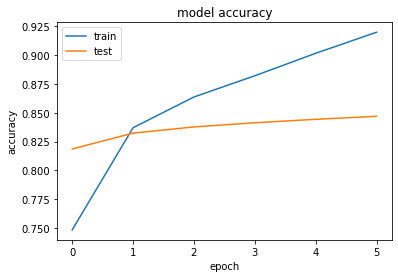

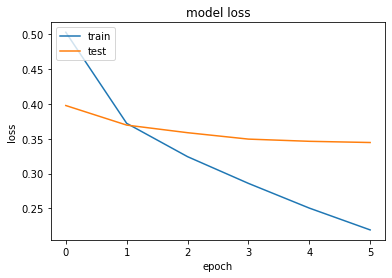

In [31]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

Petite remarque:

  - Le modèle souffre d'une *variance élevée* (high variance or overfitting) car <span style="color:red">test loss</span> est bien plus grande que <span style="color:red">train loss</span>.

# Faire des prédictions sur une seule instance

In [32]:
instance = X[200]
print(instance)

Interesting and short television movie describes some of the machinations surrounding Jay Leno replacing Carson as host of the Tonight Show Film is currently very topical given the public drama surrounding Conan Brien and Jay Leno The film does good job of sparking viewers interest in the events and showing some of the concerns of the stakeholders particularly of the NBC executives The portrayal of Ovitz was particularly compelling and interesting thought Still many of the characters were only very briefly limned or touched upon and some of the acting seemed perfunctory Nevertheless an interesting story 


In [33]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.99637854]], dtype=float32)

In [34]:
if np.round(model.predict(instance)[0])[0]==1:
    print('The review is postive')
else:
    print('The review is negative')

The review is postive


# 3 - RNN

# 3-1 -  LSTM

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/LSTM_cell.svg/300px-LSTM_cell.svg.png'>

In [35]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [37]:
tic = time()
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
toc = time()
time3 = (toc-tic)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 162s 650ms/step - loss: 0.5394 - acc: 0.7263 - val_loss: 0.4440 - val_acc: 0.7940
Epoch 2/6
250/250 [==============================] - 84s 337ms/step - loss: 0.4560 - acc: 0.7878 - val_loss: 0.4203 - val_acc: 0.8116
Epoch 3/6
250/250 [==============================] - 119s 475ms/step - loss: 0.4134 - acc: 0.8112 - val_loss: 0.3802 - val_acc: 0.8280
Epoch 4/6
250/250 [==============================] - 170s 682ms/step - loss: 0.3692 - acc: 0.8348 - val_loss: 0.3610 - val_acc: 0.8409
Epoch 5/6
250/250 [==============================] - 165s 662ms/step - loss: 0.3469 - acc: 0.8466 - val_loss: 0.3401 - val_acc: 0.8516
Epoch 6/6
313/313 [==============================] - 31s 98ms/step - loss: 0.3560 - acc: 0.8433


In [38]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracy_LSTM = score[1]

Test Score: 0.35599005222320557
Test Accuracy: 0.8432999849319458


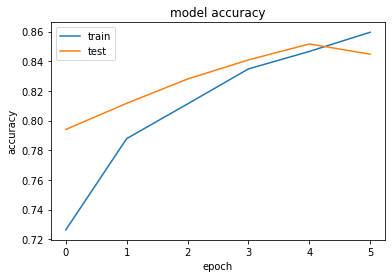

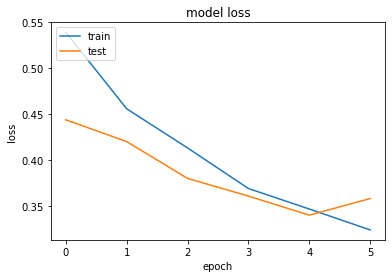

In [39]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Faire des prédictions sur une seule instance

In [40]:
instance = X[6200]
print(instance)

Think you ve seen the worst movie in the world Think again The person who designed the cover of this box should be accused of false advertising The cover makes it look like good scary horror suspense thriller But no What we have instead is NIGHTSCREAM movie that makes sweeeoooowww noise every time credit flashes across the screen The biggest name in the entire film is probably Casper Van Dien who hardly has part voted one for this one only because couldn vote any lower If could vote something like negative five thousand trust me would have So for now m going to give NIGHTSCREAM out of just because it ended 


In [41]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.81275654]], dtype=float32)

# 3-2 -  GRU

 
On  crée tout d'abord  un modèle Sequential (). Ensuite, nous créons notre couche embedding_layer , cette couche aura  une longueur d'entrée de 100, la dimension du vecteur de sortie sera également de 100. Ensuite on ajoute notre GRU model avec 128 neuron.Finalement on ajoute une couche dense  avec un seul neuron en  utilisant une fonction d'activation sigmoid.
Pour compiler le modèle on va utiliser l'optimiseur adam , binary_crossentropy comme fonction de perte et précision comme métrique, puis nous imprimerons le summary de notre modèle.

In [42]:
#création du modèle:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [43]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,343,149
Trainable params: 88,449
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [44]:
# 3) entrainement du modèle:

Dans le scipt ci-dessous, nous utilisons la méthode fit pour entraîner notre réseau neuronal. La valeur validation_split de 0,2 signifie que 20% des données d'apprentissage sont utilisées pour evaluer la précision de  l'algorithme.À la fin de l'entrainement on constate une précision de  85,89%.

In [46]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 107s 428ms/step - loss: 0.5248 - acc: 0.7234 - val_loss: 0.4007 - val_acc: 0.8141
Epoch 2/6
250/250 [==============================] - 134s 538ms/step - loss: 0.3945 - acc: 0.8214 - val_loss: 0.3627 - val_acc: 0.8381
Epoch 3/6
250/250 [==============================] - 131s 523ms/step - loss: 0.3609 - acc: 0.8402 - val_loss: 0.3480 - val_acc: 0.8456
Epoch 4/6
250/250 [==============================] - 135s 540ms/step - loss: 0.3362 - acc: 0.8521 - val_loss: 0.3337 - val_acc: 0.8506
Epoch 5/6
250/250 [==============================] - 128s 513ms/step - loss: 0.3110 - acc: 0.8655 - val_loss: 0.3337 - val_acc: 0.8569
Epoch 6/6
313/313 [==============================] - 23s 75ms/step - loss: 0.3217 - acc: 0.8634


In [47]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.32168060541152954
Test Accuracy: 0.8633999824523926


In [48]:
# 4) évaluation du  modèle:

nous pouvons voir à partir des résultat precedants  qu'il y a une très petite différence entre la précision d'entraînement et la précision du test, ce qui signifie qu'il n'y a pas de surapprentissage concernant le modèle implémenter .Pour s'assurer encore on va faire le plot des  différents métriques  de perte et de précision entre les ensembles d'entraînement et de test.

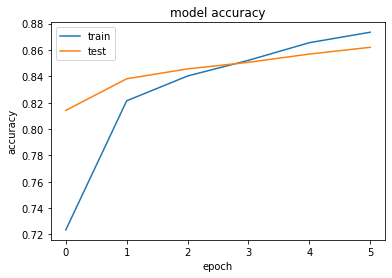

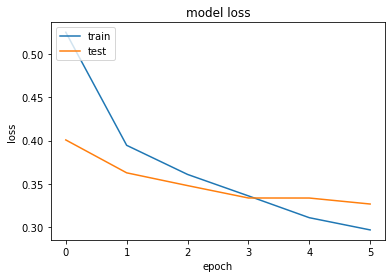

In [49]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

On peut facilement constater que la différence entre la précision des données test et presque la meme pour les données d'entrainement .De meme la différence entre les valeurs de perte est également négligeable contrairement au resultats des autres modèles.On peut géneralement conclure que le modèle est  performant .

In [50]:
# 5) effectuer la  prédiction en  utilisant le modèle implémenter:

Pour effectuer la prédiction on va choisir d'une manière aléatoire un commentaire et on va essayer de voir est ce que notre modèle est bien capable de prédir la sortie correcte .

In [51]:
#making prediction for new instance
instance = X[9]
print(instance)

If you like original gut wrenching laughter you will like this movie If you are young or old then you will love this movie hell even my mom liked it Great Camp 


**Il s'agit bien d'un commentaire positif est ce que le modèle sera capable de prédir c'est ce qu'on va voir.**

Avant d'effectuer la prédiction il sera necessaire d'effectuer des prétraitements pour cela on va procéder de la meme manière que la partie traitement de données .

In [52]:
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)


In [53]:
model.predict(instance)

array([[0.9249996]], dtype=float32)

le modèle a bien prédis le resultat il s'agit bien d'un commentaire positif 

In [54]:
# 6)  Augmenter les performances du modèle:

In [55]:
#making the result better:
model.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])

In [56]:
tic = time()
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
toc = time()
time4 = (toc-tic)
score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 144s 576ms/step - loss: 0.2607 - acc: 0.8896 - val_loss: 0.3255 - val_acc: 0.8618
Epoch 2/6
250/250 [==============================] - 139s 557ms/step - loss: 0.2601 - acc: 0.8897 - val_loss: 0.3247 - val_acc: 0.8611
Epoch 3/6
250/250 [==============================] - 136s 545ms/step - loss: 0.2598 - acc: 0.8900 - val_loss: 0.3240 - val_acc: 0.8614
Epoch 4/6
250/250 [==============================] - 135s 542ms/step - loss: 0.2595 - acc: 0.8903 - val_loss: 0.3235 - val_acc: 0.8612
Epoch 5/6
250/250 [==============================] - 137s 546ms/step - loss: 0.2593 - acc: 0.8903 - val_loss: 0.3231 - val_acc: 0.8615
Epoch 6/6
313/313 [==============================] - 31s 98ms/step - loss: 0.3174 - acc: 0.8626


In [57]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
accuracy_GRU = score[1]

Test Score: 0.31738221645355225
Test Accuracy: 0.8626000285148621


# Analyse des resultats:

In [58]:
data_rows = [('training time(sec)',round(time1), round(time2), round(time3), round(time4)),
                ('','','','',''),
            ('accuracy %',round(100*accuracy_NN), round(100*accuracy_CNN), round(100*accuracy_LSTM), round(100*accuracy_GRU)),
                 ('','','','','')]
t = Table(rows=data_rows, names=('metric','Simmple Neural Network', 'CNN', 'LSTM', 'GRU'))
print('--------------------------------Tableau récapitulatif------------------------\n\n')
print(t)

--------------------------------Tableau récapitulatif------------------------


      metric       Simmple Neural Network CNN LSTM GRU
------------------ ---------------------- --- ---- ---
training time(sec)                     36 351  875 834
                                                      
        accuracy %                     74  86   84  86
                                                      


In [60]:
# Les resultats change a chaque fois